Kaggle Usernames : 
Vaishali Raja , 
Nicolas Linsenmaier

Best Score: 0.11881
Ranking : 659

Data Exploration

In [123]:
import warnings
import numpy as np
from numpy import math
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'png' #retina

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import skew,norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import Lasso,  BayesianRidge, LassoLarsIC


In [124]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

ID's are unique identifiers and can be removed from the datasets before conducting any training or testing

In [125]:
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

Print number of rows / columns in train and test set

In [126]:
print('Train Data: \n')
print("Number of columns: "+ str(train.shape[1]))
print("Number of rows: "+ str(train.shape[0]))
print('\nTest Data: \n')
print("Number of columns: "+ str(test.shape[1]))
print("Number of rows: "+ str(test.shape[0]))

Train Data: 

Number of columns: 80
Number of rows: 1460

Test Data: 

Number of columns: 79
Number of rows: 1459


Statistics Summary of Sales Price

In [127]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Data Exploration

We'll be exploring the numerical and categorical variables of the training dataset. 

In [128]:
categorical_features = pd.DataFrame(train.describe(include = ['O'])).columns

numerical_features = list(train.select_dtypes(include=[np.number]).columns.values)

print('Categorical features: \n')
print(str(categorical_features))

print('Numerical Features: \n')
print(str(numerical_features))

Categorical features: 

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numerical Features: 

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAb

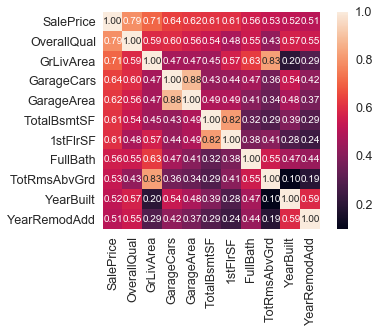

In [129]:
corr_matrix = train.corr()

k = 11 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

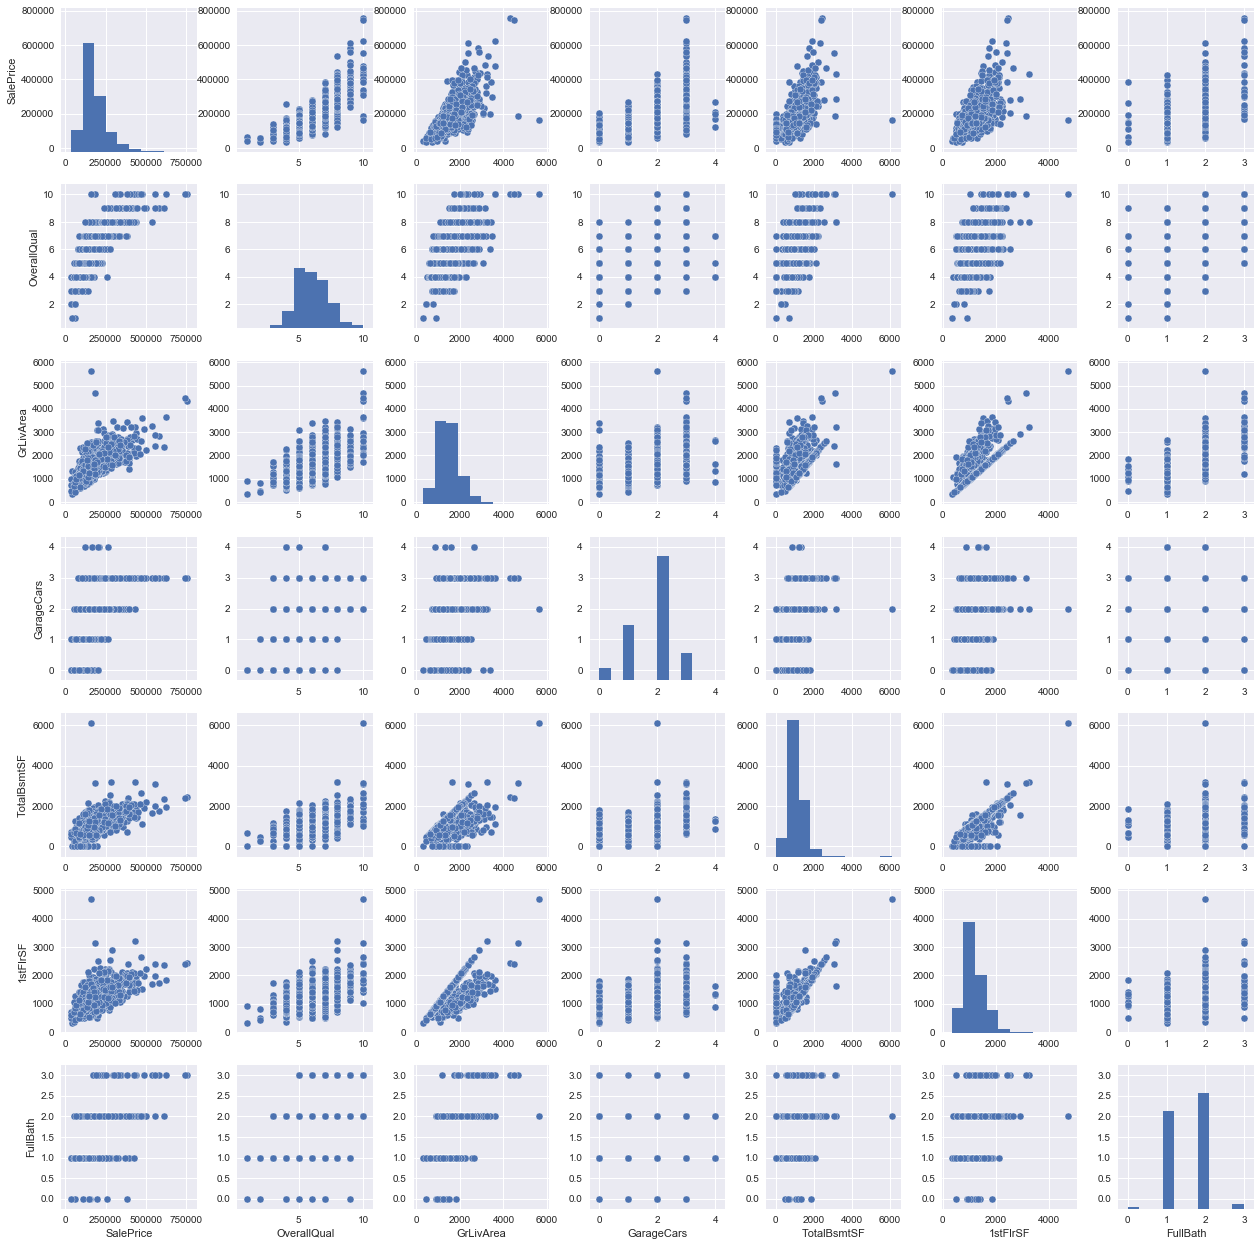

In [130]:
#Create a grid plot of the relationship between the top few variables that have a high correlation with SalePrice
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath']
sns.pairplot(train[cols], size = 2.5)
plt.show()

Data Cleaning :
    To easily clean the dataset, we are going to be merging the training and testing datasets. But before we do that, we will extract the target variable of Sales Price and evaluate if any transformations need to be performed. Once that has been completed, the merged dataset (sans SalesPrice) will be split into categorical and numerical sets for data imputation and cleaning. 
   After a few rounds of base model running, we'll be removing some outliers from the training dataset before proceedig further to see if improvements can be made on the RMSE. 

Outlier removal based on scatter plot above :

In [131]:
print("Dim of training dataset before outlier removal : "+ str(train.shape))

train = train.drop(train[train['GrLivArea'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF']> 6000].index)
train = train.drop(train[train['1stFlrSF']>4000].index)

print("Dim after outlier removal: " + str(train.shape))

Dim of training dataset before outlier removal : (1460, 80)
Dim after outlier removal: (1456, 80)


With oulier removal done, we will be looking at the SalePrice and check if any transformation is required.

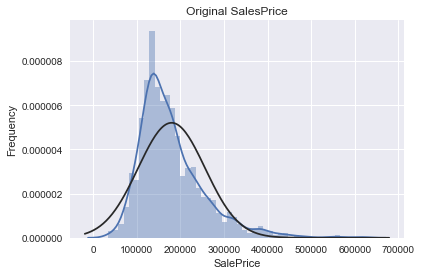

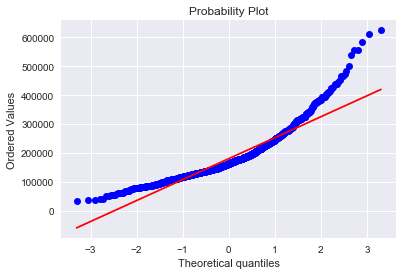

Skewness: 1.565959
Kurtosis: 3.885283


In [132]:
#Density plot of SalePrice
sns.distplot(train.SalePrice, fit=norm, bins=50)
plt.ylabel('Frequency')
plt.title('Original SalesPrice')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

From the graphs, we can see that the Sales Price is positively skewed and shows a sharp peak. The high kurtosis also shows a heavy tail. This is not recommended for linear models and thus, would require a log transformation. 

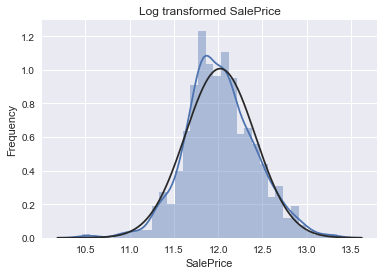

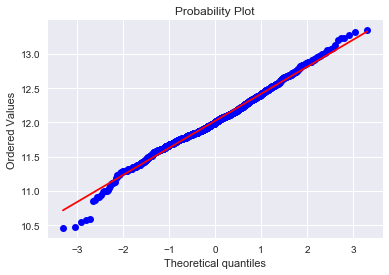

In [133]:
#log transform the Salesprice
train["SalePrice"] = np.log1p(train["SalePrice"])

# Density plot of log transformed SalesPrice
sns.distplot(train.SalePrice,fit=norm);
plt.ylabel('Frequency')
plt.title('Log transformed SalePrice');

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Now that we have the target variable transformed, we will keep that aside while merging the test and train datasets for data cleaning. 

In [134]:
#Drop target variable from train dataset
target = train['SalePrice']
train = train.drop(["SalePrice"], axis=1)

In [135]:
print('Train Data before merge: \n')
print("Number of columns: "+ str(train.shape[1]))
print("Number of rows: "+ str(train.shape[0]))
print('\nTest Data before merge: \n')
print("Number of columns: "+ str(test.shape[1]))
print("Number of rows: "+ str(test.shape[0]))

m_data = pd.concat([train, test], ignore_index=True)

print('\nMerged Data: \n')
print("Number of columns: "+ str(m_data.shape[1]))
print("Number of rows: "+ str(m_data.shape[0]))

Train Data before merge: 

Number of columns: 79
Number of rows: 1456

Test Data before merge: 

Number of columns: 79
Number of rows: 1459

Merged Data: 

Number of columns: 79
Number of rows: 2915


In [136]:
#Split merged data into numerical and categorical data and check out the percentage of NA's in each col. 

cat_columns = [col for col in m_data.columns.values if m_data[col].dtype == 'object']

# dataframe with categorical features
data_cat = m_data[cat_columns]

print('Checks: \n')
print("Number of columns: "+ str(data_cat.shape[1]))
print("Number of rows: "+ str(data_cat.shape[0]))
print("Column Names: "+ str(data_cat.columns))

#Percentage of missing values in Categorical Variable
data_cat_na = (data_cat.isnull().sum() / len(data_cat)) * 100
data_cat_na = data_cat_na.drop(data_cat_na[data_cat_na == 0].index).sort_values(ascending=False)[:30]
missing_data_c = pd.DataFrame({'Missing Ratio for Categorical Var' :data_cat_na})
print('\n Missing Ratio for Cat variable: \n')
print("Table: " + str(missing_data_c))

Checks: 

Number of columns: 43
Number of rows: 2915
Column Names: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

 Missing Ratio for Cat variable: 

Table:               Missing Ratio for Categorical Var
PoolQC                                99.725557
MiscFeature                           96.397942
Alley                                 93.207547
Fence                            

In [137]:
# dataframe with numerical features
data_num = m_data.drop(cat_columns, axis=1)

print('Checks: \n')
print("Number of columns: "+ str(data_num.shape[1]))
print("Number of rows: "+ str(data_num.shape[0]))
print("Column Names: "+ str(data_num.columns))

#Percentage of missing values in Numerical Variables
data_num_na = (data_num.isnull().sum() / len(data_num)) * 100
data_num_na = data_num_na.drop(data_num_na[data_num_na == 0].index).sort_values(ascending=False)[:30]
missing_data_n = pd.DataFrame({'Missing % of NA in Numerical Var' :data_num_na})
print('\n Missing % of NA in Num variable: \n')
print("Table: " + str(missing_data_n))

Checks: 

Number of columns: 36
Number of rows: 2915
Column Names: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

 Missing % of NA in Num variable: 

Table:               Missing % of NA in Numerical Var
LotFrontage                          16.672384
GarageYrBlt                           5.454545
MasVnrArea                            0.789022
BsmtHalfBath                          0.068611
BsmtFullBath                          0.068611
GarageArea                  

Upon investigating the variables, we found that the following cleaning and transformations needed to be performed :
1. Impute certain categorical values that have the value NA with "None"
2. Impute certain numerical values that have the value NA with '0'
3. Use the mode/median value to impute values with the value NA (depending on the variable)
4. Remove variables that do not provide additional value to the dataset. 

After each transformation/cleaning, a check is done on the percentage of variables with NA so as to understand what further transformations are required. 
Once it has been checked there are no NA values left in the merged dataset, the following actions will be performed: 
1. Create new features based on existing variables (this was performed after some initial runs on the original dataset)
2. Use labelencoder to create ordinal values from some categorical values
3. Reduce skewness of some numerical variables by applying log transformation

In [138]:
#Impute categorical variables with "None"

for col in ('PoolQC','MiscFeature','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','GarageType','Alley','Fence','FireplaceQu','GarageFinish', 'GarageQual', 'GarageCond','MasVnrType'):
    data_cat[col] = data_cat[col].fillna('None')
    
data_cat.isnull().values.any()

#Percentage of missing values in Categorical Variable
data_cat_na = (data_cat.isnull().sum() / len(data_cat)) * 100
data_cat_na = data_cat_na.drop(data_cat_na[data_cat_na == 0].index).sort_values(ascending=False)[:30]
missing_data_c = pd.DataFrame({'Missing % of NA in Categorical Var' :data_cat_na})
print('\n Missing % of NA in Cat variable: \n')
print("Table: " + str(missing_data_c))


 Missing % of NA in Cat variable: 

Table:              Missing % of NA in Categorical Var
MSZoning                               0.137221
Functional                             0.068611
Utilities                              0.068611
SaleType                               0.034305
KitchenQual                            0.034305
Electrical                             0.034305
Exterior2nd                            0.034305
Exterior1st                            0.034305


In [139]:
#Impute numerical variable with '0'

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea','MSSubClass'):
    data_num[col] = data_num[col].fillna(0)
    
data_num.isnull().values.any()

#Percentage of missing values in Numerical Variables
data_num_na = (data_num.isnull().sum() / len(data_num)) * 100
data_num_na = data_num_na.drop(data_num_na[data_num_na == 0].index).sort_values(ascending=False)[:30]
missing_data_n = pd.DataFrame({'Missing % of NA in Numerical Var' :data_num_na})
print('\n Missing % of NA in Num variable: \n')
print("Table: " + str(missing_data_n))


 Missing % of NA in Num variable: 

Table:              Missing % of NA in Numerical Var
LotFrontage                         16.672384


In [140]:
#Setting the mode or the most common value for the following Variables

for col in ('MSZoning','Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    data_cat[col] = data_cat[col].fillna(data_cat[col].mode()[0])
    
# Functional : NA = typical
data_cat["Functional"] = data_cat["Functional"].fillna("Typ")


data_cat.isnull().values.any() 

#Percentage of missing values in Categorical Variable
data_cat_na = (data_cat.isnull().sum() / len(data_cat)) * 100
data_cat_na = data_cat_na.drop(data_cat_na[data_cat_na == 0].index).sort_values(ascending=False)[:30]
missing_data_c = pd.DataFrame({'Missing % of NA in Categorical Var' :data_cat_na})
print('\n Missing % of NA in Cat variable: \n')
print("Table: " + str(missing_data_c))


 Missing % of NA in Cat variable: 

Table:            Missing % of NA in Categorical Var
Utilities                            0.068611


In [141]:
#Imputing missing value by using the median value of LotFrontage by the neighbourhood
data_num["LotFrontage"] = data_num.groupby(data_cat["Neighborhood"])["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#Percentage of missing values in Numerical Variables
data_num_na = (data_num.isnull().sum() / len(data_num)) * 100
data_num_na = data_num_na.drop(data_num_na[data_num_na == 0].index).sort_values(ascending=False)[:30]
missing_data_n = pd.DataFrame({'Missing Ratio for Numerical Var' :data_num_na})
print('\n Missing Ratio for Num variable: \n')
print("Table: " + str(missing_data_n))


 Missing Ratio for Num variable: 

Table: Empty DataFrame
Columns: [Missing Ratio for Numerical Var]
Index: []


In [142]:
#Removing Utilities variables as all the values are 'AllPub' except for 3 values which are 'NoSeWa' and 'NA'.This does not provide additional value to the regression models. 
data_cat = data_cat.drop(['Utilities'], axis=1)

#Percentage of missing values in Categorical Variable
data_cat_na = (data_cat.isnull().sum() / len(data_cat)) * 100
data_cat_na = data_cat_na.drop(data_cat_na[data_cat_na == 0].index).sort_values(ascending=False)[:30]
missing_data_c = pd.DataFrame({'Missing % of NA in Categorical Var' :data_cat_na})
print('\n Missing % of NA in Cat variable: \n')
print("Table: " + str(missing_data_c))


 Missing % of NA in Cat variable: 

Table: Empty DataFrame
Columns: [Missing % of NA in Categorical Var]
Index: []


Now that we have confirmed that both the categorical and numerical values have no NA values, we move on to feature engineering and data transformations.

In [143]:
#Adding an additional feature with total square feet
data_num['TotalSF'] = data_num['TotalBsmtSF'] + data_num['1stFlrSF'] + data_num['2ndFlrSF']

#Combining 4 columns into 1 variable and dropping the existing variables.
data_num["TotBath"] = data_num["FullBath"] + 0.5*data_num["HalfBath"] + data_num["BsmtFullBath"] + 0.5*data_num["BsmtHalfBath"]

data_num = data_num.drop("FullBath",1)
data_num = data_num.drop("HalfBath",1)
data_num = data_num.drop("BsmtFullBath",1)
data_num = data_num.drop("BsmtHalfBath",1)

Checking the length of the data_cat and data_num

In [144]:

print('Checks_Data_num: \n')
print("Number of columns: "+ str(data_num.shape[1]))
print("Number of rows: "+ str(data_num.shape[0]))
print("Column Names: "+ str(data_num.columns))

print('Checks_Data_cat: \n')
print("Number of columns: "+ str(data_cat.shape[1]))
print("Number of rows: "+ str(data_cat.shape[0]))
print("Column Names: "+ str(data_cat.columns))

#Notice the changes in column from the data cleaning and feature creation

Checks_Data_num: 

Number of columns: 34
Number of rows: 2915
Column Names: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'TotBath'],
      dtype='object')
Checks_Data_cat: 

Number of columns: 42
Number of rows: 2915
Column Names: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       

In [145]:
#Label Encoding categorical variables with ordinality
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data_cat[c].values)) 
    data_cat[c] = lbl.transform(list(data_cat[c].values))
    

In [146]:
#Get skewness for numerical features and apply box-cox transformation (log transformation was tried initially but box-cox provided better results)

skew_features = data_num.apply(lambda x: skew(x.dropna())).sort_values(ascending=False) 
skewness = pd.DataFrame({'Skew' :skew_features})
skewness.head(6)

,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845


In [147]:
#Apply box-cox transformation for numerical variables with skewness more than 0.75
skewness = skewness[abs(skewness) > 0.75]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    data_num[feat] = boxcox1p(data_num[feat], lam)

In [148]:
#Obtain dummy variables from the categorical data set
data_cat = pd.get_dummies(data_cat)


Now that all cleaning and transformations are performed, the categorical and numerical data will be merged and split into train and testing datasets.

In [149]:
#Merging datasets and printing out the dimensions of the merged dataset.
data = pd.concat([data_num, data_cat], axis=1)
print(data.shape)

(2915, 217)


In [150]:
#Creating train and test sets

n_train = train.shape[0]
n_test = test.shape[0]
y_train= target
train = pd.DataFrame(data[:n_train])
test = pd.DataFrame(data[n_train:])

print(train.shape)
print(test.shape)

(1456, 217)
(1459, 217)


Regression Modelling : 
    
   We created a cross validation function using the K-Fold method. We also used a couple of linear modelling methods, namely Lasso and Ridge. These techniques were used individually first for the first few runs and then an ensemble was created using a combination of these 2 methods. 

In [151]:
n_folds = 5

def rmsle_cv(model):
    k_f = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = k_f))
    return(rmse)

Implementing  Regression (V5)
- Using Lasso regression
- Using Kernel Ridge
- Doing an ensemble of both models

In [152]:
#Base Model 1 : Lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#Base Model 2: Ridge
kernel_ridge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [153]:
score = rmsle_cv(lasso)
print("\nLasso RMSE score: {:.5f}\n".format(score.mean()))

score = rmsle_cv(kernel_ridge)
print("Kernel Ridge RMSE score: {:.5f}\n".format(score.mean()))


Lasso RMSE score: 0.11158

Kernel Ridge RMSE score: 0.11462



In [154]:
# Defining rmsle evaluation function for predictions
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Final Training and Prediction using the different linear regression techniques.

In [155]:
# Lasso Regression training and predictions

lasso.fit(train.values, y_train)
lasso_train_pred = lasso.predict(train.values)
lasso_pred = np.expm1(lasso.predict(test.values))
print( "RMSE score for Lasso: " + str(rmsle(y_train, lasso_train_pred)))

RMSE score for Lasso: 0.101324915068


In [156]:
# Kernel_ridge Regression training and predictions

kernel_ridge.fit(train.values, y_train)
kernel_ridge_train_pred = kernel_ridge.predict(train.values)
kernel_ridge_pred = np.expm1(kernel_ridge.predict(test.values))
print("RMSE score for Kernel Ridge: " + str(rmsle(y_train, kernel_ridge_train_pred)))

RMSE score for Kernel Ridge: 0.0795000081563


Creating and ensemble of linear regression techniques. Initial attempts were with a higher weightage on kernal ridge as the individual RMSE scores for kernel ridge were better, but submissions to Kaggle yielded worse scores. A higher weightage on lasso, however, was more successful. 

In [157]:
ensemble_linear = 0.3*kernel_ridge_pred + 0.7*lasso_pred

Finally, a csv file was created as an output in line with Kaggle requirements. 

In [158]:
final = pd.DataFrame()
final['Id'] = test_ID
final['SalePrice'] = ensemble_linear
final.to_csv('submission.csv',index=False)